# Testing Deferred Revenue in Python
Will this be easier for everyone to use than Matlab?

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

## Step 1: Processing Base Billings Data

In [2]:
df = pd.read_excel('../data/all_billings_inputs.xlsx', sheet_name='base_billings')

In [3]:
df.sample(10)

,Document Currency,Enterprise BU Desc,Frequency,Invoice Fiscal Year Period Desc,Product Config Type,Rev Rec Category,Rule For Bill Date,Sales Type,Subscription Term,Completed Sales ( DC ),Completed Sales
35642,SEK,Document Cloud,NaN,2018-08,1Y,A,NaN,DEFERRED,1,166.33,18.34
11186,DKK,Document Cloud,NaN,2019-03,NaN,NaN,NaN,RECOGNIZED,0,11880.00,1808.01
18883,EUR,Other Solutions,NaN,2019-02,NaN,NaN,NaN,RECOGNIZED,0,-13305.80,-15158.98
18520,EUR,Experience Cloud,ONGO,2020-01,ONORE,D,YH,DEFERRED,0,482526.30,531993.59
40485,USD,Document Cloud,NaN,2016-04,1Y,D,Y3,DEFERRED,0,200.00,200.00
11651,DKK,Experience Cloud,ACTL,2017-09,ONORE,NaN,NaN,RECOGNIZED,0,20000.00,3167.20
5479,BRL,Creative,NaN,2020-02,NaN,NaN,NaN,RECOGNIZED,0,21672.00,5288.73
11802,DKK,Experience Cloud,ONGO,2018-02,ONORE,D,YQ,DEFERRED,0,534045.00,85457.88
42628,USD,DX Other,ONGO,2018-12,1Y,D,YQ,DEFERRED,12,327250.00,327250.00
35173,SEK,Creative,NaN,2020-02,NaN,NaN,NaN,RECOGNIZED,0,307307.00,32589.70


## Changing the column names early since they are inconsistent across other reports

In [4]:
df.columns

Index(['Document Currency', 'Enterprise BU Desc', 'Frequency',
       'Invoice Fiscal Year Period Desc', 'Product Config Type',
       'Rev Rec Category', 'Rule For Bill Date', 'Sales Type',
       'Subscription Term', 'Completed Sales ( DC )', 'Completed Sales'],
      dtype='object')

In [5]:
df.rename(index = str, columns = {'Document Currency': 'curr',
                                 'Enterprise BU Desc': 'BU',
                                 'Invoice Fiscal Year Period Desc': 'period',
                                 'Product Config Type': 'config',
                                 'Rev Rec Category': 'rev_req_type',
                                 'Rule For Bill Date': 'rebill_rule',
                                 'Completed Sales ( DC )': 'DC_amount',
                                 'Completed Sales': 'US_amount'}, inplace=True)

In [6]:
df.columns

Index(['curr', 'BU', 'Frequency', 'period', 'config', 'rev_req_type',
       'rebill_rule', 'Sales Type', 'Subscription Term', 'DC_amount',
       'US_amount'],
      dtype='object')

## Filter that removes any currency that has  < 10 transactions. 


In [7]:
# creates a list of the currencies and the number of transactions for each currency
vc = df['curr'].value_counts()
print(vc)

USD    12427
EUR     7725
GBP     5714
AUD     5068
JPY     4919
CHF     2389
SEK     2260
DKK     2172
NOK     1854
CAD     1520
HKD      486
BRL      466
RUB      461
KRW      247
CLP      211
COP      210
ARS      210
SGD      209
PEN      190
INR      181
PHP      151
TWD      148
THB      144
MYR      138
IDR      132
NZD       67
ILS       38
TRY       27
SAR        4
BMD        2
AED        1
MXP        1
Name: curr, dtype: int64


In [8]:
# Create variable that is true if the number of transaction is greater than 10, false otherwise
keep_these = vc.values > 10
# filtering only currencies that were greater than 10
keep_curr = vc[keep_these]
a = keep_curr.index
# filtering the dataframe to remove any of teh currencies not in our list
df = df[df['curr'].isin(a)]

## Just keeping track of the currencies we removed in our model_dict data structure

In [9]:
remove_these = vc[vc.values <= 10].index
model_dict = {'curr_removed': list(vc[remove_these].index)}
delete_curr = list(remove_these)

## The FX database does not have information on the following currencies
 - AED (United Arab Emirates Dirham)
 - BMD (Bermudan Dollar)
 - MXP (Mexican Peso)
 - TRY (Turkish Lira)

In [10]:
if 'TRY' not in model_dict:
    model_dict['curr_removed'].append('TRY')
    delete_curr.append('TRY')
    a = a.drop('TRY')
    
print('Model dictionary', model_dict)
print('Deleted Currencies', delete_curr)

Model dictionary {'curr_removed': ['SAR', 'BMD', 'AED', 'MXP', 'TRY']}
Deleted Currencies ['SAR', 'BMD', 'AED', 'MXP', 'TRY']


In [11]:
print("---Removing infrequent currencies from billings history---")
print('Total number of currencies in the base billings file: ', len(vc))
if len(model_dict['curr_removed'])==0:
    print('No currencies were removed, all contained 10 or more billings')
    print('Currencies in the base billings file')
    for item in a:
        print(a[item], end = " ")
else:
    print('\n Currencies were removed: ', len(model_dict['curr_removed']))

    for item in remove_these:
        print(item, ', ', end="")
        
    print("\n\n{} Remaining currencies: ".format(len(a)))
    for item in a:
        print(item, ', ', end="")

---Removing infrequent currencies from billings history---
Total number of currencies in the base billings file:  32

 Currencies were removed:  5
SAR , BMD , AED , MXP , 

27 Remaining currencies: 
USD , EUR , GBP , AUD , JPY , CHF , SEK , DKK , NOK , CAD , HKD , BRL , RUB , KRW , CLP , COP , ARS , SGD , PEN , INR , PHP , TWD , THB , MYR , IDR , NZD , ILS , 

# Removing any of the values that are zero

In [12]:
print('This is the length of the dataframe before removing zeros: ', len(df))
df = df[df['DC_amount']!=0]
print('This is the length of the dataframe after removing zeros: ', len(df))

This is the length of the dataframe before removing zeros:  49764
This is the length of the dataframe after removing zeros:  46285


In [13]:
df.sample(10)

,curr,BU,Frequency,period,config,rev_req_type,rebill_rule,Sales Type,Subscription Term,DC_amount,US_amount
40251,USD,Document Cloud,NaN,2015-07,NaN,A,NaN,DEFERRED,1,-4004.22,-4004.22
17183,EUR,Experience Cloud,ONGO,2015-11,1Y,D,Y1,DEFERRED,12,11572.99,12941.90
48628,USD,Print & Publishing,NaN,2016-04,1V,NaN,NaN,RECOGNIZED,0,57189.25,57189.25
34844,SEK,Creative,NaN,2017-05,1Y,A,NaN,DEFERRED,1,42826.12,4809.74
29272,JPY,Experience Cloud,1TME,2015-08,ONORE,D,Y1,DEFERRED,0,-9572180.00,-78054.78
49399,USD,Print & Publishing,NaN,2019-06,NaN,A,NaN,DEFERRED,1,67240.00,67240.00
26231,IDR,Creative,NaN,2020-04,MTHLY,D,Y3,DEFERRED,1,90812227.52,6430.71
5521,BRL,Document Cloud,NaN,2018-07,MTHLY,A,NaN,DEFERRED,1,-810.00,-213.74
43149,USD,Experience Cloud,NaN,2017-07,1Y,D,YA,DEFERRED,0,389488.70,389488.70
43924,USD,Experience Cloud,1TME,2017-01,OUNIV,NaN,NaN,PRO-SVC-INV,0,73606.00,73606.00


## Clearing out the Non-Revenue billings from the file
 - No Idea what these are

In [14]:
df["Sales Type"].value_counts()

DEFERRED       37628
RECOGNIZED      7183
PRO-SVC-INV     1323
NON-REV          150
Name: Sales Type, dtype: int64

In [15]:
print('Length of the dataframe before removing non-revenue billings: ', len(df))
df = df[df['Sales Type']!='NON-REV']
print('Length of the dataframe after removing non-revenue billings:  ', len(df))


Length of the dataframe before removing non-revenue billings:  46285
Length of the dataframe after removing non-revenue billings:   46135


## Starting to group the revenue by period, industry, etc

Attempting to group by the following categories
 - currency
 - period
 - sale type
 
May need to process the data differently with the deferred billings so we will start with the recognized and then the service billings

# DOING THIS ALL IN PANDAS WITH SPLIT APPLY COMBINE on Sales Type 


In [16]:
# First split the data into three dataframes
# Recognized billings
rec = df[df['Sales Type']=='RECOGNIZED']
svc = df[df['Sales Type']=='PRO-SVC-INV']
dfr = df[df['Sales Type']=='DEFERRED']

# NOW WORKING ON THE BILLINGS

### Recognized Revenue

In [17]:
rec.sample(10)

,curr,BU,Frequency,period,config,rev_req_type,rebill_rule,Sales Type,Subscription Term,DC_amount,US_amount
24892,GBP,Print & Publishing,NaN,2015-02,2V,NaN,NaN,RECOGNIZED,0,2785.00,4274.36
33744,NZD,Experience Cloud,ONGO,2019-11,NaN,NaN,NaN,RECOGNIZED,0,149424.42,94463.08
49598,USD,Print & Publishing,NaN,2020-02,1V,NaN,NaN,RECOGNIZED,0,21934.00,21934.00
20449,GBP,Creative,NaN,2017-01,IDRT,NaN,NaN,RECOGNIZED,0,2260.36,2839.83
34099,RUB,Creative,NaN,2018-04,NaN,NaN,NaN,RECOGNIZED,0,53067.00,929.59
10889,DKK,Document Cloud,NaN,2016-10,NaN,NaN,NaN,RECOGNIZED,0,23660.00,3556.50
46419,USD,Experience Cloud,ONGO,2017-07,ONORE,NaN,NaN,RECOGNIZED,0,223455.58,223455.58
9374,CHF,LiveCycle,NaN,2018-03,NaN,NaN,NaN,RECOGNIZED,0,2957.00,3167.68
12478,EUR,Creative,NaN,2015-10,1V,NaN,NaN,RECOGNIZED,0,14098.00,15907.86
18995,EUR,Print & Publishing,NaN,2015-03,1V,NaN,NaN,RECOGNIZED,0,23783.00,27045.53


In [18]:
# testing groupby object
gb_rec = rec.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [19]:
# the Subscription term hangs around. We are dropping that here
gb_rec.drop(labels='Subscription Term', axis=1,inplace =True)

In [20]:
gb_rec.sample(10)

,curr,BU,period,DC_amount,US_amount
1056,EUR,Creative,2015-04,1.568760e+06,1674118.63
1787,GBP,Print & Publishing,2019-10,2.895600e+04,35580.60
2638,SEK,Document Cloud,2017-04,1.193100e+04,1336.39
2483,NZD,Experience Cloud,2019-02,1.159434e+04,7857.15
2499,PEN,Creative,2019-08,2.944400e+02,89.56
751,CLP,Creative,2019-07,9.723400e+04,140.27
280,AUD,Print & Publishing,2015-11,8.247100e+04,58788.38
326,AUD,Print & Publishing,2019-09,7.486473e+04,51472.01
1836,JPY,Creative,2015-01,2.386011e+08,2009190.60
1124,EUR,Document Cloud,2015-07,2.975199e+06,3332871.12


## Now doing this for the service billings

In [21]:
# testing groupby object
gb_svc = svc.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [22]:
gb_svc.drop(labels='Subscription Term', axis=1,inplace =True)
gb_svc.head(5)

,curr,BU,period,DC_amount,US_amount
0,AUD,Experience Cloud,2015-01,25075.00,21084.51
1,AUD,Experience Cloud,2015-02,-4750.00,-4220.74
2,AUD,Experience Cloud,2015-03,424271.75,337822.37
3,AUD,Experience Cloud,2015-04,297925.00,229116.23
4,AUD,Experience Cloud,2015-05,316894.82,237310.85


# NOW WORKING ON DEFERRED BILLINGS

## Type B billings are service agreements that will have invoices submitted before the billings are reclassified to revenue. If no invoices are assigned to the billings, the billings become revenue in 12 months

In [23]:
# filter out the type B first then do a group_by
dfr_b = dfr[dfr['rev_req_type']=='B']

In [24]:
gb_b = dfr_b.groupby(['curr', 'BU', 'period'], as_index=False).sum()

In [25]:
gb_b.drop(labels='Subscription Term', axis=1, inplace=True)

In [26]:
gb_b.head(10)

,curr,BU,period,DC_amount,US_amount
0,AUD,Creative,2017-10,8544.0,6837.59
1,AUD,DX Other,2017-04,13205.0,10082.02
2,AUD,DX Other,2017-08,27400.0,21259.93
3,AUD,DX Other,2018-07,6635.4,4908.74
4,AUD,DX Other,2018-08,7535.0,5561.43
5,AUD,Document Cloud,2017-12,3283.2,2494.58
6,AUD,Document Cloud,2018-06,3425.0,2592.18
7,AUD,Document Cloud,2018-12,3425.0,2483.47
8,AUD,Document Cloud,2019-03,4375.0,3122.00
9,AUD,Experience Cloud,2015-01,157510.0,131675.74


In [27]:
print('length of deferred billings : ', len(dfr))
print('length of the type B billings: ', len(dfr_b))

length of deferred billings :  37628
length of the type B billings:  1434


## Now Type A Billings
These billings are on a billing plan. The product config tells us how long before they renew

 - '2Y' = 24 months
 - '1Y' = 12 months
 - 'MTHLY' = 1 month
 
NOTE: There are also other fields in the 'Product Configtype ID' field that do not map well to a rebill period.
To fix this, we need to load up a different file and determine the length of the sales contract (type A no config)
 

In [28]:
# filtering just the type A billings
dfr_a = dfr[dfr['rev_req_type']=='A']

In [29]:
gb_a = dfr_a.groupby(['curr', 'BU', 'period',
                     'config'], as_index=False).sum()
gb_a.drop(labels='Subscription Term', axis=1, inplace = True)

In [30]:
gb_a.sample(10)

,curr,BU,period,config,DC_amount,US_amount
2108,GBP,Creative,2016-05,MTHLY,-10148.11,-14473.66
1480,EUR,Creative,2018-09,2Y,284262.70,327171.29
1858,EUR,LiveCycle,2019-01,1Y,112199.32,127249.94
3343,NOK,Creative,2018-06,1Y,-37611.31,-4670.73
3543,SEK,Creative,2016-04,MTHLY,-16297.39,-1967.55
1971,EUR,Print & Publishing,2016-05,1Y,364199.95,412403.36
4049,USD,DX Other,2017-11,OCONS,209775.00,209775.00
3641,SEK,Document Cloud,2016-08,1Y,-1240.71,-145.46
770,CAD,Print & Publishing,2016-12,1Y,57982.22,43031.35
1692,EUR,Document Cloud,2019-07,1Y,5218916.92,5831555.87


In [31]:
gb_a['config'].value_counts()

1Y       2418
MTHLY     950
2Y        875
OUNIV     231
OCONS     106
3Y        101
ONORE      32
OENSV       1
1V          1
Name: config, dtype: int64

### Below is just a check to see how large the billing types are across all periods

In [32]:
gb_a_config = gb_a.groupby(['config'], as_index=False).sum()
gb_a_config

,config,DC_amount,US_amount
0,1V,6.503000e+03,6.503000e+03
1,1Y,1.198135e+11,9.655797e+09
2,2Y,2.470307e+08,6.719101e+07
3,3Y,9.380464e+08,4.051346e+06
4,MTHLY,1.381940e+08,3.985406e+07
5,OCONS,3.903233e+07,1.028252e+07
6,OENSV,-1.200000e+02,-1.200000e+02
7,ONORE,2.350904e+06,2.015485e+06
8,OUNIV,4.283761e+06,3.473767e+06


### These 'OCONS', 'ONORE' and 'OUNIV' data types are not actual product config IDs so we have to get them from a different data file. We are excluding these types below.

In [33]:
config_list = ['1Y', '2Y', '3Y', 'MTHLY']
test1 = gb_a[gb_a['config'].isin(config_list)]


In [34]:
test1.sample(5)

,curr,BU,period,config,DC_amount,US_amount
4130,USD,Document Cloud,2016-11,2Y,605967.00,605967.00
3504,RUB,Document Cloud,2018-07,MTHLY,-3932.31,-62.17
4195,USD,Document Cloud,2018-08,2Y,173801.00,173801.00
4599,USD,Print & Publishing,2015-09,MTHLY,-52.40,-52.40
1746,EUR,Experience Cloud,2016-04,1Y,814888.36,904568.33


## For now, lets just split this into gb_a_1Y, gb_a_2Y, gb_a_3y, gb_a_1M


In [35]:
gb_a_1Y = test1[test1['config']=='1Y']
gb_a_2Y = test1[test1['config']=='2Y']
gb_a_3Y = test1[test1['config']=='3Y']
gb_a_1M = test1[test1['config']=='MTHLY']

In [36]:
print('this is the lenght of type A 1M billings: ', len(gb_a_1M))
print('this is the lenght of type A 1Y billings: ', len(gb_a_1Y))
print('this is the lenght of type A 2Y billings: ', len(gb_a_2Y))
print('this is the lenght of type A 3Y billings: ', len(gb_a_3Y))

this is the lenght of type A 1M billings:  950
this is the lenght of type A 1Y billings:  2418
this is the lenght of type A 2Y billings:  875
this is the lenght of type A 3Y billings:  101


# TYPE D billings
These billings have a field 'Rule For Bill Date' that determines when new billings will occur
 - Monthly [Y1, Y2, Y3, Y5]
 - Quarterly [YQ]
 - Every 4 months [YT]
 - Semi-annual [YH]
 - Annual [YA, YC]
 - Every 2 years - [Y4]
 
 We also need to track the type D billings that do not have a 'Rule for Bill Date'

In [37]:
# for now just do a groupby on the type
# filtering just the type A billings
dfr_d = dfr[dfr['rev_req_type']=='D']

In [38]:
gb_d = dfr_d.groupby(['curr', 'BU', 'period',
                     'rebill_rule'], as_index=False).sum()
gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [43]:
gb_d_mthly = gb_d[gb_d['rebill_rule'].isin(['Y1', 'Y2', 'Y3', 'YM'])]
gb_d_qtrly = gb_d[gb_d['rebill_rule'].isin(['YQ', 'YY'])]
gb_d_four_mths = gb_d[gb_d['rebill_rule']=='YT']
gb_d_semi_ann = gb_d[gb_d['rebill_rule']=='YH']
gb_d_annual = gb_d[gb_d['rebill_rule'].isin(['YA', 'YC', 'YX'])]
gb_d_two_yrs = gb_d[gb_d['rebill_rule']=='Y4']
gb_d_three_yrs = gb_d[gb_d['rebill_rule']=='Y7']

In [44]:
gb_d['rebill_rule'].value_counts()

YA    2952
Y3    2375
YQ     991
YH     547
Y1     491
YC     490
Y2     153
Y4      57
Y7      31
YM      23
YX      12
YT      10
YY      10
Name: rebill_rule, dtype: int64

## Note: There are only 8 payments (back from 2017) that paid on a 4 month basis. 
We will ignore these as well.

In [46]:
print('Length of monthly', len(gb_d_mthly))
print('Length of quarterly', len(gb_d_qtrly))
print('Length of four months', len(gb_d_four_mths))
print('Length of semi ann', len(gb_d_semi_ann))
print('Length of annual', len(gb_d_annual))
print('Length of two years', len(gb_d_two_yrs))
print('Length of three years', len(gb_d_three_yrs))

Length of monthly 3042
Length of quarterly 1001
Length of four months 10
Length of semi ann 547
Length of annual 3454
Length of two years 57
Length of three years 31


## NOW WE NEED TO BUILD A DATAFRAME THAT INTEGRATES THIS DATA

- We will have the following descriptive fields
   - Invoicing Fiscal Year-Period
   - Document Currency
   - Enterprise BU

- We will have the following fields based on rebilling rule
   - Recognized
   - Service
   - Monthly
   - Quarterly
   - Annual
   - Two Years
   - Three Years

In [48]:
# We need to do it this way when we get to a .py file!
list_df = [gb_rec, gb_svc, gb_b,
        gb_a_1M,    gb_a_1Y,    gb_a_2Y,       gb_a_3Y, 
        gb_d_mthly, gb_d_qtrly, gb_d_semi_ann, gb_d_annual, gb_d_two_yrs, gb_d_three_yrs]

list_columns = ['recognized', 'service', 'deferred_B', 
    'deferred_1M_a', 'deferred_1Y_a', 'deferred_2Y_a', 'deferred_3Y_a',
    'deferred_1M_d', 'deferred_3M_d', 'deferred_6M_d', 'deferred_1Y_d', 'deferred_2Y_d', 'deferred_3Y_d']


In [49]:
def merge_new_dataframe(old_df, new_df, new_column):
    df_merged = pd.merge(old_df, new_df, how='outer', 
                     left_on=['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
    df_merged.rename(index=str, columns={'DC_amount': new_column+'_DC', 'US_amount': new_column+'_US'}, inplace=True)
    
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'config'
    rule_str = 'rebill_rule'
    if config_str in df_merged.columns:
        df_merged.drop(columns=['config'], inplace=True)
    
    if rule_str in df_merged.columns:
        df_merged.drop(columns=['rebill_rule'], inplace=True)
        
    return df_merged

In [50]:
def merge_all_dataframes(list_df, list_columns):
    for i, df in enumerate(list_df):
        print('This is i:', i)
        #print("This is the df: ", df.head())
        print('referencing the column: ', list_columns[i])

        if i==0:
            df_merged = list_df[0].copy()
            df_merged.rename(index=str, columns={'DC_amount': list_columns[i]+'_DC', 
                                                 'US_amount': list_columns[i]+'_US'}, inplace=True)
        else:
            df_merged = merge_new_dataframe(df_merged, df, list_columns[i])

    return df_merged
    

In [56]:
def clean_df_columns(df):
    
    # clean up NaNs before adding 
    df = df.fillna(value=0)
    
    # DC columns first
    # Monthly
    df['deferred_1M_DC'] = df['deferred_1M_a_DC']+df['deferred_1M_d_DC']
    df.drop(labels=['deferred_1M_a_DC', 'deferred_1M_d_DC'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y_DC'] = df['deferred_1Y_a_DC']+df['deferred_1Y_d_DC']
    df.drop(labels=['deferred_1Y_a_DC', 'deferred_1Y_d_DC'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y_DC'] = df['deferred_2Y_a_DC']+df['deferred_2Y_d_DC']
    df.drop(labels=['deferred_2Y_a_DC', 'deferred_2Y_d_DC'], axis=1, inplace=True)
    
    #Three-Year
    df['deferred_3Y_DC'] = df['deferred_3Y_a_DC']+df['deferred_3Y_d_DC']
    df.drop(labels=['deferred_3Y_a_DC', 'deferred_3Y_d_DC'], axis=1, inplace=True)
    
    # renaming 3M and 6M
    df.rename(index=str, columns = {'deferred_3M_d_DC':'deferred_3M_DC', 
                               'deferred_6M_d_DC': 'deferred_6M_DC'}, inplace=True)

    # US columns
    # Monthly
    df['deferred_1M_US'] = df['deferred_1M_a_US']+df['deferred_1M_d_US']
    df.drop(labels=['deferred_1M_a_US', 'deferred_1M_d_US'], axis=1, inplace=True)
    
    # Annual
    df['deferred_1Y_US'] = df['deferred_1Y_a_US']+df['deferred_1Y_d_US']
    df.drop(labels=['deferred_1Y_a_US', 'deferred_1Y_d_US'], axis=1, inplace=True)
    
    # Two-Year
    df['deferred_2Y_US'] = df['deferred_2Y_a_US']+df['deferred_2Y_d_US']
    df.drop(labels=['deferred_2Y_a_US', 'deferred_2Y_d_US'], axis=1, inplace=True)
    
    # Three-Year
    df['deferred_3Y_US'] = df['deferred_3Y_a_US']+df['deferred_3Y_d_US']
    df.drop(labels=['deferred_3Y_a_US', 'deferred_3Y_d_US'], axis=1, inplace=True)
    
    # renaming 3M and 6M
    df.rename(index=str, columns = {'deferred_3M_d_US':'deferred_3M_US', 
                               'deferred_6M_d_US': 'deferred_6M_US'}, inplace=True)

    
    #cleaning up the longer column names
    df.rename(index=str, columns = {'curr': 'curr',
                               'BU':'BU',
                               'period':'period'}, inplace=True)
    
    return df

In [57]:
df = merge_all_dataframes(list_df, list_columns)

This is i: 0
referencing the column:  recognized
This is i: 1
referencing the column:  service
This is i: 2
referencing the column:  deferred_B
This is i: 3
referencing the column:  deferred_1M_a
This is i: 4
referencing the column:  deferred_1Y_a
This is i: 5
referencing the column:  deferred_2Y_a
This is i: 6
referencing the column:  deferred_3Y_a
This is i: 7
referencing the column:  deferred_1M_d
This is i: 8
referencing the column:  deferred_3M_d
This is i: 9
referencing the column:  deferred_6M_d
This is i: 10
referencing the column:  deferred_1Y_d
This is i: 11
referencing the column:  deferred_2Y_d
This is i: 12
referencing the column:  deferred_3Y_d


In [58]:
df = clean_df_columns(df)

In [59]:
df.sample(10)

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_3M_DC,...,deferred_6M_DC,deferred_6M_US,deferred_1M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC,deferred_1M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US
4974,ARS,Creative,2019-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,4.195650e+05,2.413800e+05,0.00,0.00,1.077456e+04,6.194450e+03,0.00,0.00
2692,JPY,Other Solutions,2018-07,-389748.00,-3560.63,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.00
2816,NOK,Creative,2017-05,176730.00,20585.87,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.048789e+07,2.097387e+06,0.00,0.00,1.221901e+06,2.443935e+05,0.00,0.00
3641,USD,Creative,2018-03,6641659.00,6641659.00,100000.00,100000.00,10200.00,10200.00,751942.77,...,47618.23,47618.23,9.837556e+05,7.915374e+07,183191.55,12774.96,9.837556e+05,7.758676e+07,183191.55,12774.96
3685,USD,Creative,2019-04,6029601.76,6029601.76,0.00,0.00,0.00,0.00,10970821.11,...,141360.00,141360.00,1.437689e+08,1.249438e+08,77654.22,1295.13,1.437689e+08,1.243743e+08,77654.22,1295.13
5473,GBP,DX Other,2016-12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.000000e+00,1.970266e+05,0.00,0.00,0.000000e+00,2.436002e+05,0.00,0.00
1182,DKK,Print & Publishing,2019-10,7450.00,1100.59,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.942600e+04,2.670000e+03,0.00,0.00,2.874100e+03,3.940700e+02,0.00,0.00
2018,GBP,Experience Cloud,2017-12,1012519.06,1335274.71,1427575.14,1892594.09,674803.82,892843.75,3064167.99,...,232178.75,308665.98,1.200000e+04,7.633765e+06,0.00,0.00,1.587876e+04,1.010733e+07,0.00,0.00
4907,CAD,Print & Publishing,2019-06,0.00,0.00,0.00,0.00,0.00,0.00,25285.00,...,0.00,0.00,0.000000e+00,1.804521e+05,0.00,0.00,0.000000e+00,1.343026e+05,0.00,0.00
3514,USD,Creative,2015-06,31105538.88,31105538.88,179021.88,179021.88,17700.16,17700.16,714356.34,...,92888.32,92888.32,2.849234e+05,8.272946e+07,132701.06,0.00,2.849234e+05,8.245111e+07,132701.06,0.00


In [60]:
df.columns

Index(['curr', 'BU', 'period', 'recognized_DC', 'recognized_US', 'service_DC',
       'service_US', 'deferred_B_DC', 'deferred_B_US', 'deferred_3M_DC',
       'deferred_3M_US', 'deferred_6M_DC', 'deferred_6M_US', 'deferred_1M_DC',
       'deferred_1Y_DC', 'deferred_2Y_DC', 'deferred_3Y_DC', 'deferred_1M_US',
       'deferred_1Y_US', 'deferred_2Y_US', 'deferred_3Y_US'],
      dtype='object')

In [ ]:
# Make this a function to be cleaned up somehow
del dfr
del dfr_a
del dfr_b
del dfr_d
del gb_a
del gb_a_1M
del gb_a_1Y
del gb_a_2Y
del gb_a_3Y
del gb_b, 
del gb_d
del gb_svc, gb_rec, gb_d_two_yrs
del gb_d_four_mths, gb_d_qtrly, gb_d_semi_ann


In [62]:
df.sample(10)

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_3M_DC,...,deferred_6M_DC,deferred_6M_US,deferred_1M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC,deferred_1M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US
5026,CHF,Print & Publishing,2020-04,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,2.236000e+03,3.890000e+02,0.0,0.0,2326.00,399.83,0.00,0.00
3847,USD,Document Cloud,2017-01,1.373709e+07,13737094.85,0.00,0.00,0.00,0.00,21959.83,...,4470.00,4470.00,3.007519e+06,9.157822e+06,685802.0,0.0,3007518.91,9157822.12,685802.00,0.00
2481,JPY,Document Cloud,2018-06,4.389002e+08,3995478.19,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.810919e+07,2.998283e+08,1569948.0,4409028.0,165069.85,2651573.14,14313.95,14019.11
5158,KRW,Document Cloud,2019-04,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.925326e+06,6.872720e+05,0.0,0.0,1704.63,611.83,0.00,0.00
2050,GBP,Experience Cloud,2019-02,9.762687e+05,1246579.51,641072.14,826331.83,75362.90,95907.69,1509455.67,...,358148.80,453488.01,8.870970e+03,3.709816e+06,0.0,0.0,11348.03,4730891.00,0.00,0.00
5014,BRL,Print & Publishing,2019-08,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,2.610000e+03,0.000000e+00,0.0,0.0,687.03,0.00,0.00,0.00
3280,SEK,Experience Cloud,2016-06,1.277274e+05,15655.87,1418821.00,170584.85,0.00,0.00,1420459.58,...,-1753.08,216.17,0.000000e+00,4.066377e+06,0.0,0.0,0.00,490273.46,0.00,0.00
2363,JPY,Creative,2017-07,5.888201e+07,531886.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.136110e+09,1.424077e+09,151200.0,0.0,10265021.07,9907613.66,1357.78,0.00
2501,JPY,Document Cloud,2019-08,2.935108e+08,2718986.88,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.731313e+07,1.924798e+08,12033.0,76219092.0,160320.53,1595827.09,110.94,323689.16
498,CAD,Experience Cloud,2017-06,3.118006e+04,22750.84,521093.14,386800.89,24884.39,17791.74,428162.41,...,0.00,0.00,3.004716e+04,6.424774e+05,0.0,0.0,22245.80,471878.54,0.00,0.00


# Now working on the ZCC billings

These billings are type D billings that did not populate the rebill_rule field of the database.

They have a 'sales document type' = 'ZCC"

The billings themselves are being created from a tableau report that looks for additions to the deferred revenue waterfall based on billings of type D and have a sales document type of ZCC

# TO BE DONE:

1. Clean up the type F billings (at least check to see if they are necessary)
2. Make a function to delete all intermediate dataframes
3. Add type A no config function
4. Add type D ZCC billings

5. Work on the forecast part of this

6. Load up FX rates

In [63]:
# Adobe financial calendar
df_cal = pd.read_excel('../data/old/ADOBE_FINANCIAL_CALENDAR.xlsx', 'ADBE_cal')

In [64]:
df_cal.head()

,Year,Quarter,Period,Qtr_Ticker,Qtr_Start,Qtr_End,Per_Ticker,Per_Start,Per_End
0,2010,1,1,Q1_10,2009-11-28,2010-03-05,P1_10,2009-11-28,2010-01-01
1,2010,1,2,Q1_10,2009-11-28,2010-03-05,P2_10,2010-01-02,2010-01-29
2,2010,1,3,Q1_10,2009-11-28,2010-03-05,P3_10,2010-01-30,2010-03-05
3,2010,2,4,Q2_10,2010-03-06,2010-06-04,P4_10,2010-03-06,2010-04-02
4,2010,2,5,Q2_10,2010-03-06,2010-06-04,P5_10,2010-04-03,2010-04-30


## Working on Type A billings with no configuration

 - this is included in the all_billings_inputs file on the 'type_A_no_config' sheet

# Type A No Config Type Billings

This file contains type A billings that have a revenue contract start date and end date. We need to map these into the terms of our dataframe.

### Steps:
1. Rename the columns
2. This file has entries for pennies. Need to clear out anything less than $10 in absolute value
3. Determine the length of time between start date and end date
4. Group this dataframe by currency, period and BU
5. Merge this final dataframe with the larger dataframe

## NOTE: This file contains two different start date and end date columns. We need to look at all of them

In [98]:
df_A = pd.read_excel('../data/all_billings_inputs.xlsx', sheet_name='type_A_no_config')


In [99]:
df_A.sample(10)

,Document Currency,Enterprise BU Desc,Invoice Fiscal Year Period Desc,Rev Rec Contract End Date Hdr,Rev Rec Contract End Date Item,Rev Rec Contract Start Date Hdr,Rev Rec Contract Start Date Item,Completed Sales ( DC ),Completed Sales
268710,USD,Print & Publishing,2015-08,NaT,2015-07-27,NaT,2015-06-28,3829.00,3829.00
52664,EUR,Document Cloud,2017-11,NaT,2018-10-13,NaT,2017-10-16,-49.99,-59.05
13035,AUD,Document Cloud,2017-04,NaT,2018-01-25,NaT,2017-03-10,-24.22,-18.49
153885,USD,Document Cloud,2017-02,NaT,2017-04-02,NaT,2017-01-20,-4.72,-4.72
153468,USD,Document Cloud,2017-02,NaT,2017-02-17,NaT,2017-01-07,-2.68,-2.68
94543,JPY,Document Cloud,2016-12,NaT,2017-06-24,NaT,2016-11-27,-1378.00,-12.25
112799,USD,Creative,2016-11,NaT,2017-09-19,NaT,2016-09-20,3940.49,3940.49
259292,USD,Document Cloud,2018-10,NaT,2019-08-24,NaT,2018-09-17,-46.25,-46.25
242445,USD,Document Cloud,2018-07,NaT,2019-02-03,NaT,2018-06-22,-29.66,-29.66
100221,JPY,Document Cloud,2018-07,NaT,2019-01-16,NaT,2018-06-21,-1378.00,-12.48


In [101]:
df_A.columns

Index(['Document Currency', 'Enterprise BU Desc',
       'Invoice Fiscal Year Period Desc', 'Rev Rec Contract End Date Hdr',
       'Rev Rec Contract End Date Item', 'Rev Rec Contract Start Date Hdr',
       'Rev Rec Contract Start Date Item', 'Completed Sales ( DC )',
       'Completed Sales'],
      dtype='object')

In [103]:
df_A.rename(index=str, columns={'Document Currency':'currency', 
                               'Enterprise Bu':'BU',
                               'Invoicing Fiscal Year-Period Desc':'period',
                               'Rev Rec Contract End Date Hdr':'end_date_1',
                               'Rev Rec Contract End Date Item':'end_date_2',
                               'Rev Rec Contract Start Date Hdr': 'start_date_1',
                               'Rev Rec Contract Start Date Item': 'start_date_2',
                               'Completed Sales ( DC )':'DC_amount',
                               'Completed Sales': 'US_amount'
                               }, inplace=True)



In [104]:
df_A.columns

Index(['currency', 'Enterprise BU Desc', 'Invoice Fiscal Year Period Desc',
       'end_date_1', 'end_date_2', 'start_date_1', 'start_date_2', 'DC_amount',
       'US_amount'],
      dtype='object')

### Dealing with the duplicate dates by taking a max

In [105]:
df_A.head()

,currency,Enterprise BU Desc,Invoice Fiscal Year Period Desc,end_date_1,end_date_2,start_date_1,start_date_2,DC_amount,US_amount
0,AUD,Creative,2015-01,NaT,2014-12-09,NaT,2014-11-10,12.49,10.68
1,AUD,Creative,2015-01,NaT,2014-12-29,NaT,2014-11-30,44.96,38.44
2,AUD,Creative,2015-01,NaT,2014-12-31,NaT,2014-12-01,14.98,12.80
3,AUD,Creative,2015-01,NaT,2015-01-01,NaT,2014-12-02,668.96,571.90
4,AUD,Creative,2015-01,NaT,2015-01-02,NaT,2014-12-03,49.96,42.72


In [112]:
df_A['start_date_str'] = df_A[['start_date_1','start_date_2']].max(axis=1).astype(str)
df_A['end_date_str'] = df_A[['end_date_1','end_date_2']].max(axis=1).astype(str)

In [113]:
df_A.sample(10)

,currency,Enterprise BU Desc,Invoice Fiscal Year Period Desc,end_date_1,end_date_2,start_date_1,start_date_2,DC_amount,US_amount,start_date_str,end_date_str
90174,JPY,Document Cloud,2015-03,NaT,2016-02-16,NaT,2015-02-17,930920.00,7800.32,2015-02-17,2016-02-16
16396,AUD,Document Cloud,2017-11,NaT,2018-01-05,NaT,2017-10-08,-6.71,-5.25,2017-10-08,2018-01-05
202771,USD,Document Cloud,2017-11,NaT,2018-10-14,NaT,2017-10-19,-281.03,-281.03,2017-10-19,2018-10-14
231021,USD,Document Cloud,2018-05,NaT,2018-09-08,NaT,2018-04-06,-10.17,-10.17,2018-04-06,2018-09-08
228274,USD,Document Cloud,2018-04,NaT,2019-02-03,NaT,2018-03-28,-201.98,-201.98,2018-03-28,2019-02-03
54797,EUR,Document Cloud,2018-02,NaT,2019-01-06,NaT,2018-01-18,-20.28,-24.37,2018-01-18,2019-01-06
119685,USD,Creative,2019-12,NaT,2019-10-25,NaT,2019-09-26,7089.77,7089.77,2019-09-26,2019-10-25
108500,USD,Creative,2015-01,NaT,2014-12-23,NaT,2014-11-24,5.99,5.99,2014-11-24,2014-12-23
70595,GBP,Document Cloud,2016-11,NaT,2016-10-31,NaT,2016-10-02,-5.75,-7.47,2016-10-02,2016-10-31
170945,USD,Document Cloud,2017-05,NaT,2017-12-06,NaT,2017-04-06,-60.32,-60.32,2017-04-06,2017-12-06


<class 'pandas.core.frame.DataFrame'>
Index: 271726 entries, 0 to 271725
Data columns (total 11 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   currency                         271726 non-null  object        
 1   Enterprise BU Desc               271726 non-null  object        
 2   Invoice Fiscal Year Period Desc  271726 non-null  object        
 3   end_date_1                       510 non-null     datetime64[ns]
 4   end_date_2                       271518 non-null  datetime64[ns]
 5   start_date_1                     510 non-null     datetime64[ns]
 6   start_date_2                     271518 non-null  datetime64[ns]
 7   DC_amount                        271726 non-null  float64       
 8   US_amount                        271726 non-null  float64       
 9   start_date_str                   271726 non-null  object        
 10  end_date_str                     271726 non-null 

In [115]:
df_A['start_date'] = pd.to_datetime(df_A['start_date_str'])
df_A['end_date'] = pd.to_datetime(df_A['end_date_str'])

In [116]:
df_A.drop(labels=['end_date_1', 'end_date_2', 'start_date_1', 'start_date_2',
                  'start_date_str', 'end_date_str'], axis=1, inplace=True)

In [117]:
df_A['month_interval']=(df_A['end_date']-df_A['start_date'])

In [118]:
df_A.sample(10)

,currency,Enterprise BU Desc,Invoice Fiscal Year Period Desc,DC_amount,US_amount,start_date,end_date,month_interval
184687,USD,Document Cloud,2017-08,-10.21,-10.21,2017-07-20,2017-12-22,155 days
15866,AUD,Document Cloud,2017-10,-3.02,-2.40,2017-09-02,2017-10-12,40 days
46378,EUR,Document Cloud,2017-03,-55.33,-58.72,2017-02-22,2018-02-17,360 days
186660,USD,Document Cloud,2017-08,-62.49,-62.49,2017-07-25,2018-06-15,325 days
137489,USD,Document Cloud,2016-11,-7.26,-7.26,2016-09-13,2017-01-02,111 days
223833,USD,Document Cloud,2018-03,-64.41,-64.41,2018-03-02,2019-01-31,335 days
237321,USD,Document Cloud,2018-06,-13.93,-13.93,2018-05-10,2018-12-28,232 days
98294,JPY,Document Cloud,2017-11,-2400.00,-21.29,2017-10-12,2018-10-05,358 days
14332,AUD,Document Cloud,2017-06,-27.46,-20.52,2017-05-30,2018-05-28,363 days
118229,USD,Creative,2018-08,4467.18,4467.18,2018-07-05,2019-07-04,364 days


In [119]:
df_A['months']= (df_A['month_interval']/ np.timedelta64(1,'M')).round(0)

In [120]:
df_A.month_interval.describe()

count                      271726
mean     223 days 18:20:25.287218
std      141 days 14:29:04.293030
min               0 days 00:00:00
25%              89 days 00:00:00
50%             252 days 00:00:00
75%             358 days 00:00:00
max            4016 days 00:00:00
Name: month_interval, dtype: object

### Now I need to map the months into the different integers in my dataframe


In [121]:
list_rebills = [1, 3, 6, 12, 24, 36]
temp_rebill = np.zeros_like(df_A['months'])
for i in range(len(df_A)):
    temp_rebill[i] = min(list_rebills, key=lambda x:abs(x-df_A['months'][i]))
df_A['rebill_months']=temp_rebill


In [122]:
df_A.sample(10)

,currency,Enterprise BU Desc,Invoice Fiscal Year Period Desc,DC_amount,US_amount,start_date,end_date,month_interval,months,rebill_months
122823,USD,Document Cloud,2015-05,-1035.12,-1035.12,2015-02-09,2016-02-08,364 days,12.0,12.0
108441,SEK,Document Cloud,2018-11,-186.54,-21.12,2018-10-03,2019-09-18,350 days,11.0,12.0
48823,EUR,Document Cloud,2017-06,-16.66,-18.15,2017-05-19,2018-03-14,299 days,10.0,12.0
228013,USD,Document Cloud,2018-04,-20.80,-20.80,2018-03-09,2019-01-20,317 days,10.0,12.0
241323,USD,Document Cloud,2018-07,-6.59,-6.59,2018-06-04,2018-10-02,120 days,4.0,3.0
92467,JPY,Document Cloud,2016-03,-4800.00,-42.52,2016-03-01,2017-03-01,365 days,12.0,12.0
183839,USD,Document Cloud,2017-08,-3.81,-3.81,2017-07-14,2017-09-10,58 days,2.0,1.0
71161,GBP,Document Cloud,2016-11,-7.47,-9.15,2016-10-27,2017-05-29,214 days,7.0,6.0
143498,USD,Document Cloud,2016-11,-56.84,-56.84,2016-10-26,2017-09-15,324 days,11.0,12.0
115744,USD,Creative,2017-12,-9.99,-9.99,2017-11-29,2017-12-26,27 days,1.0,1.0


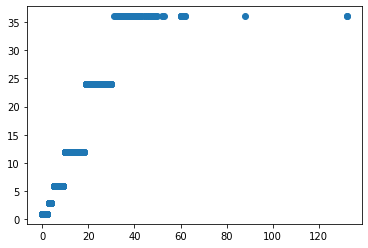

In [85]:
plt.scatter(df_A['months'], df_A['rebill_months'])

## Grouping the dataframe by rebill_months

In [123]:
# drop what we dont need
df_A.drop(columns = ['start_date', 'end_date', 'month_interval', 'months'], axis=1, inplace=True)

In [124]:
df_A.head()

,currency,Enterprise BU Desc,Invoice Fiscal Year Period Desc,DC_amount,US_amount,rebill_months
0,AUD,Creative,2015-01,12.49,10.68,1.0
1,AUD,Creative,2015-01,44.96,38.44,1.0
2,AUD,Creative,2015-01,14.98,12.80,1.0
3,AUD,Creative,2015-01,668.96,571.90,1.0
4,AUD,Creative,2015-01,49.96,42.72,1.0


In [129]:
df_A.rename(index = str, columns={'currency': 'curr', 'Enterprise BU Desc':'BU', 
             'Invoice Fiscal Year Period Desc': 'period'}, inplace=True)


In [130]:
df_A.head(10)

,curr,BU,period,DC_amount,US_amount,rebill_months
0,AUD,Creative,2015-01,12.49,10.68,1.0
1,AUD,Creative,2015-01,44.96,38.44,1.0
2,AUD,Creative,2015-01,14.98,12.80,1.0
3,AUD,Creative,2015-01,668.96,571.90,1.0
4,AUD,Creative,2015-01,49.96,42.72,1.0
5,AUD,Creative,2015-01,74.94,64.08,1.0
6,AUD,Creative,2015-01,132.39,111.30,1.0
7,AUD,Creative,2015-01,194.84,163.80,1.0
8,AUD,Creative,2015-01,57.45,48.12,1.0
9,AUD,Creative,2015-01,688.94,571.55,1.0


In [138]:
#medals = df.pivot_table('no of medals', ['Year', 'Country'], 'medal')
temp_DC = df_A.pivot_table('DC_amount', ['curr', 'BU', 'period'], 'rebill_months')
temp_US = df_A.pivot_table('US_amount', ['curr', 'BU', 'period'], 'rebill_months')


In [139]:
temp_DC

rebill_months                           1.0         3.0   6.0           12.0  \
curr BU                 period                                                 
AUD  Creative           2015-01   172.835000         NaN   NaN           NaN   
                        2015-02  6449.135714  242.726667   NaN   4948.392414   
                        2015-03  6231.454186  300.000000   NaN   4515.238684   
                        2015-04  6621.168000  128.180000   NaN   6022.798621   
                        2015-05  6089.745000  300.000000   NaN   5200.928065   
...                                      ...         ...   ...           ...   
USD  Print & Publishing 2019-11  2204.583333         NaN   NaN  56466.250000   
                        2019-12  2321.481481         NaN   NaN  57593.529412   
                        2020-01  1798.400000         NaN   NaN   1193.333333   
                        2020-02  1876.521739         NaN   NaN  13127.272727   
                        2020-03  2080.000000         NaN   NaN   1443.125000   

rebill_months                          24.0  36.0  
curr BU                 period                     
AUD  Creative           2015-01         NaN   NaN  
                        2015-02  895.991176   NaN  
                        2015-03  739.925000   NaN  
                        2015-04  614.616667   NaN  
                        2015-05  636.906667   NaN  
...                                     ...   ...  
USD  Print & Publishing 2019-11         NaN   NaN  
                        2019-12         NaN   NaN  
                        2020-01         NaN   NaN  
                        2020-02         NaN   NaN  
                        2020-03         NaN   NaN  

[1369 rows x 6 columns]

In [140]:
temp_DC = temp_DC.fillna(0)
temp_US = temp_DC.fillna(0)

In [141]:
temp_US

rebill_months                           1.0         3.0   6.0           12.0  \
curr BU                 period                                                 
AUD  Creative           2015-01   172.835000    0.000000   0.0      0.000000   
                        2015-02  6449.135714  242.726667   0.0   4948.392414   
                        2015-03  6231.454186  300.000000   0.0   4515.238684   
                        2015-04  6621.168000  128.180000   0.0   6022.798621   
                        2015-05  6089.745000  300.000000   0.0   5200.928065   
...                                      ...         ...   ...           ...   
USD  Print & Publishing 2019-11  2204.583333    0.000000   0.0  56466.250000   
                        2019-12  2321.481481    0.000000   0.0  57593.529412   
                        2020-01  1798.400000    0.000000   0.0   1193.333333   
                        2020-02  1876.521739    0.000000   0.0  13127.272727   
                        2020-03  2080.000000    0.000000   0.0   1443.125000   

rebill_months                          24.0  36.0  
curr BU                 period                     
AUD  Creative           2015-01    0.000000   0.0  
                        2015-02  895.991176   0.0  
                        2015-03  739.925000   0.0  
                        2015-04  614.616667   0.0  
                        2015-05  636.906667   0.0  
...                                     ...   ...  
USD  Print & Publishing 2019-11    0.000000   0.0  
                        2019-12    0.000000   0.0  
                        2020-01    0.000000   0.0  
                        2020-02    0.000000   0.0  
                        2020-03    0.000000   0.0  

[1369 rows x 6 columns]

In [142]:
temp_flat_DC = pd.DataFrame(temp_DC.to_records())
temp_flat_US = pd.DataFrame(temp_US.to_records())

In [143]:
temp_flat_DC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1369 entries, 0 to 1368
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   curr    1369 non-null   object 
 1   BU      1369 non-null   object 
 2   period  1369 non-null   object 
 3   1.0     1369 non-null   float64
 4   3.0     1369 non-null   float64
 5   6.0     1369 non-null   float64
 6   12.0    1369 non-null   float64
 7   24.0    1369 non-null   float64
 8   36.0    1369 non-null   float64
dtypes: float64(6), object(3)
memory usage: 96.4+ KB


In [145]:
temp_flat_DC.rename(index=str, columns={'1.0':'deferred_1M_DC', 
                               '3.0':'deferred_3M_DC',
                               '6.0':'deferred_6M_DC',
                               '12.0':'deferred_1Y_DC',
                               '24.0':'deferred_2Y_DC',
                               '36.0': 'deferred_3Y_DC'}, inplace=True)

temp_flat_US.rename(index=str, columns={'1.0':'deferred_1M_US', 
                               '3.0':'deferred_3M_US',
                               '6.0':'deferred_6M_US',
                               '12.0':'deferred_1Y_US',
                               '24.0':'deferred_2Y_US',
                               '36.0': 'deferred_3Y_US'}, inplace=True)


In [148]:
temp_flat_DC.sample(10)

,curr,BU,period,deferred_1M_DC,deferred_3M_DC,deferred_6M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC
777,JPY,DX Other,2018-10,1.025000e+07,0.000000,4.995000e+06,0.000000e+00,0.0,0.0
112,AUD,Document Cloud,2017-05,-9.199556e+00,-13.936863,-2.564791e+01,-5.221270e+01,0.0,0.0
194,CHF,Document Cloud,2015-09,-5.480000e+00,0.000000,0.000000e+00,-2.688382e+01,0.0,0.0
1249,USD,LiveCycle,2016-01,3.644940e+03,0.000000,0.000000e+00,2.700783e+04,7500.0,0.0
824,JPY,Document Cloud,2018-08,-8.158889e+02,-1243.230769,-2.067783e+03,-4.306528e+03,0.0,0.0
483,EUR,Print & Publishing,2015-08,1.096000e+03,0.000000,0.000000e+00,0.000000e+00,0.0,0.0
985,SEK,Document Cloud,2018-11,-5.437696e+01,-78.721875,-1.326354e+02,-3.105217e+02,0.0,0.0
763,JPY,DX Other,2017-05,1.778714e+06,0.000000,0.000000e+00,1.713240e+07,0.0,0.0
545,GBP,Creative,2016-04,1.240000e+02,0.000000,0.000000e+00,8.414286e+01,0.0,0.0
1039,USD,Creative,2018-10,1.199491e+04,3191.750000,0.000000e+00,4.000032e+03,0.0,158.0


## Now we have to merge these two dataframes with the other billings dataframe

In [ ]:
''' def merge_new_dataframe(old_df, new_df, new_column):
    df_merged = pd.merge(old_df, new_df, how='outer', 
                     left_on=['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
    df_merged.rename(index=str, columns={'DC_amount': new_column+'_DC', 'US_amount': new_column+'_US'}, inplace=True)
    
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'config'
    rule_str = 'rebill_rule'
    if config_str in df_merged.columns:
        df_merged.drop(columns=['config'], inplace=True)
    
    if rule_str in df_merged.columns:
        df_merged.drop(columns=['rebill_rule'], inplace=True)
        
    return df_merged
'''

In [168]:
temp_flat_DC.head(10)

,curr,BU,period,deferred_1M_DC,deferred_3M_DC,deferred_6M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC
0,AUD,Creative,2015-01,172.835000,0.000000,0.0,0.000000,0.000000,0.0
1,AUD,Creative,2015-02,6449.135714,242.726667,0.0,4948.392414,895.991176,0.0
2,AUD,Creative,2015-03,6231.454186,300.000000,0.0,4515.238684,739.925000,0.0
3,AUD,Creative,2015-04,6621.168000,128.180000,0.0,6022.798621,614.616667,0.0
4,AUD,Creative,2015-05,6089.745000,300.000000,0.0,5200.928065,636.906667,0.0
5,AUD,Creative,2015-06,7410.857222,412.730000,0.0,4954.487778,608.377500,0.0
6,AUD,Creative,2015-08,7284.192982,257.045000,0.0,5985.608103,648.305882,0.0
7,AUD,Creative,2015-09,7122.768056,0.000000,0.0,5801.415278,741.312857,0.0
8,AUD,Creative,2015-10,6726.175517,128.180000,0.0,5229.060000,597.380000,0.0
9,AUD,Creative,2015-11,6896.387241,450.000000,0.0,5751.434138,672.630769,0.0


In [171]:
df_with_A = pd.merge(df, temp_flat_DC, how='outer',
                    left_on= ['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
df_with_A = df_with_A.fillna(0)

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_3M_DC_x,...,deferred_1M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US,deferred_1M_DC_y,deferred_3M_DC_y,deferred_6M_DC_y,deferred_1Y_DC_y,deferred_2Y_DC_y,deferred_3Y_DC_y
0,ARS,Creative,2019-07,6786.00,155.12,0.0,0.0,0.0,0.0,0.0,...,146091.12,21566.14,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
1,ARS,Creative,2019-08,16472.00,390.02,0.0,0.0,0.0,0.0,0.0,...,173274.71,22781.91,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2,ARS,Creative,2019-09,19205.00,405.51,0.0,0.0,0.0,0.0,0.0,...,217611.17,46297.25,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
3,ARS,Creative,2019-10,30382.19,532.13,0.0,0.0,0.0,0.0,0.0,...,181706.80,23376.52,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
4,ARS,Creative,2019-11,59049.00,1023.67,0.0,0.0,0.0,0.0,0.0,...,196031.97,25782.35,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5539,JPY,DX Other,2018-04,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.000000e+00,0.0,0.0,-11142000.0,0.0,0.0
5540,JPY,DX Other,2018-09,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,1.025000e+07,0.0,0.0,0.0,0.0,0.0
5541,JPY,DX Other,2018-11,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,1.148333e+06,0.0,0.0,0.0,0.0,0.0
5542,MXP,Experience Cloud,2017-06,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.000000e+00,0.0,84000.0,0.0,0.0,0.0


In [170]:
df_with_A.head()

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_3M_DC_x,...,deferred_1M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US,deferred_1M_DC_y,deferred_3M_DC_y,deferred_6M_DC_y,deferred_1Y_DC_y,deferred_2Y_DC_y,deferred_3Y_DC_y
0,ARS,Creative,2019-07,6786.00,155.12,0.0,0.0,0.0,0.0,0.0,...,146091.12,21566.14,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,ARS,Creative,2019-08,16472.00,390.02,0.0,0.0,0.0,0.0,0.0,...,173274.71,22781.91,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,ARS,Creative,2019-09,19205.00,405.51,0.0,0.0,0.0,0.0,0.0,...,217611.17,46297.25,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,ARS,Creative,2019-10,30382.19,532.13,0.0,0.0,0.0,0.0,0.0,...,181706.80,23376.52,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ARS,Creative,2019-11,59049.00,1023.67,0.0,0.0,0.0,0.0,0.0,...,196031.97,25782.35,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
df_with_all = pd.merge(df_with_A, temp_flat_US, how='outer',
                    left_on= ['curr', 'BU', 'period'],
                    right_on=['curr', 'BU', 'period'])
df_with_all = df_with_all.fillna(0)

In [201]:
df_with_all.fillna(0)

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_3M_DC_x,...,deferred_6M_DC_y,deferred_1Y_DC_y,deferred_2Y_DC_y,deferred_3Y_DC_y,deferred_1M_US_y,deferred_3M_US_y,deferred_6M_US_y,deferred_1Y_US_y,deferred_2Y_US_y,deferred_3Y_US_y
0,ARS,Creative,2019-07,6786.00,155.12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
1,ARS,Creative,2019-08,16472.00,390.02,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2,ARS,Creative,2019-09,19205.00,405.51,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
3,ARS,Creative,2019-10,30382.19,532.13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
4,ARS,Creative,2019-11,59049.00,1023.67,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5539,JPY,DX Other,2018-04,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,-11142000.0,0.0,0.0,0.000000e+00,0.0,0.0,-11142000.0,0.0,0.0
5540,JPY,DX Other,2018-09,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.025000e+07,0.0,0.0,0.0,0.0,0.0
5541,JPY,DX Other,2018-11,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.148333e+06,0.0,0.0,0.0,0.0,0.0
5542,MXP,Experience Cloud,2017-06,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,84000.0,0.0,0.0,0.0,0.000000e+00,0.0,84000.0,0.0,0.0,0.0


In [202]:
df_with_all.head(10)

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_3M_DC_x,...,deferred_6M_DC_y,deferred_1Y_DC_y,deferred_2Y_DC_y,deferred_3Y_DC_y,deferred_1M_US_y,deferred_3M_US_y,deferred_6M_US_y,deferred_1Y_US_y,deferred_2Y_US_y,deferred_3Y_US_y
0,ARS,Creative,2019-07,6786.00,155.12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ARS,Creative,2019-08,16472.00,390.02,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ARS,Creative,2019-09,19205.00,405.51,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ARS,Creative,2019-10,30382.19,532.13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ARS,Creative,2019-11,59049.00,1023.67,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ARS,Creative,2019-12,71355.57,1195.94,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,ARS,Creative,2020-01,79224.95,1323.41,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,ARS,Creative,2020-02,36596.00,611.42,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,ARS,Creative,2020-03,49107.00,810.06,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,ARS,Creative,2020-04,20858.00,336.07,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [203]:
df_with_all['deferred_1M_DC']= df_with_all['deferred_1M_DC_x']+df_with_all['deferred_1M_DC_y']
df_with_all['deferred_3M_DC']= df_with_all['deferred_3M_DC_x']+df_with_all['deferred_3M_DC_y']
df_with_all['deferred_6M_DC']= df_with_all['deferred_6M_DC_x']+df_with_all['deferred_6M_DC_y']
df_with_all['deferred_1Y_DC']= df_with_all['deferred_1Y_DC_x']+df_with_all['deferred_1Y_DC_y']
df_with_all['deferred_2Y_DC']= df_with_all['deferred_2Y_DC_x']+df_with_all['deferred_2Y_DC_y']
df_with_all['deferred_3Y_DC']= df_with_all['deferred_3Y_DC_x']+df_with_all['deferred_3Y_DC_y']

df_with_all['deferred_1M_US']= df_with_all['deferred_1M_US_x']+df_with_all['deferred_1M_US_y']
df_with_all['deferred_3M_US']= df_with_all['deferred_3M_US_x']+df_with_all['deferred_3M_US_y']
df_with_all['deferred_6M_US']= df_with_all['deferred_6M_US_x']+df_with_all['deferred_6M_US_y']
df_with_all['deferred_1Y_US']= df_with_all['deferred_1Y_US_x']+df_with_all['deferred_1Y_US_y']
df_with_all['deferred_2Y_US']= df_with_all['deferred_2Y_US_x']+df_with_all['deferred_2Y_US_y']
df_with_all['deferred_3Y_US']= df_with_all['deferred_3Y_US_x']+df_with_all['deferred_3Y_US_y']

In [204]:
df_with_all.drop(labels = ['deferred_1M_DC_x','deferred_1M_DC_y',
                        'deferred_3M_DC_x','deferred_3M_DC_y',
                        'deferred_6M_DC_x','deferred_6M_DC_y',
                        'deferred_1Y_DC_x','deferred_1Y_DC_y',
                        'deferred_2Y_DC_x','deferred_2Y_DC_y',
                        'deferred_3Y_DC_x','deferred_3Y_DC_y',
                        'deferred_1M_US_x','deferred_1M_US_y',   
                        'deferred_3M_US_x','deferred_3M_US_y',
                        'deferred_6M_US_x','deferred_6M_US_y',
                        'deferred_1Y_US_x','deferred_1Y_US_y',
                        'deferred_2Y_US_x','deferred_2Y_US_y',
                        'deferred_3Y_US_x','deferred_3Y_US_y'],
                 axis=1, inplace=True)

In [205]:
df_with_all.head()

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_1M_DC,...,deferred_6M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC,deferred_1M_US,deferred_3M_US,deferred_6M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US
0,ARS,Creative,2019-07,6786.00,155.12,0.0,0.0,0.0,0.0,6453291.31,...,0.0,953875.89,0.0,0.0,146091.12,0.0,0.0,21566.14,0.0,0.0
1,ARS,Creative,2019-08,16472.00,390.02,0.0,0.0,0.0,0.0,7305797.08,...,0.0,963180.00,0.0,0.0,173274.71,0.0,0.0,22781.91,0.0,0.0
2,ARS,Creative,2019-09,19205.00,405.51,0.0,0.0,0.0,0.0,10654985.72,...,0.0,2263704.00,0.0,0.0,217611.17,0.0,0.0,46297.25,0.0,0.0
3,ARS,Creative,2019-10,30382.19,532.13,0.0,0.0,0.0,0.0,10302933.07,...,0.0,1318346.81,0.0,0.0,181706.80,0.0,0.0,23376.52,0.0,0.0
4,ARS,Creative,2019-11,59049.00,1023.67,0.0,0.0,0.0,0.0,11340099.40,...,0.0,1494162.20,0.0,0.0,196031.97,0.0,0.0,25782.35,0.0,0.0


In [187]:
df_with_all.columns

Index(['curr', 'BU', 'period', 'recognized_DC', 'recognized_US', 'service_DC',
       'service_US', 'deferred_B_DC', 'deferred_B_US', 'deferred_1M_DC_x',
       'deferred_1M_US_x', 'deferred_1M_DC_y', 'deferred_1M_US_y',
       'deferred_3M_DC', 'deferred_6M_DC', 'deferred_1Y_DC', 'deferred_2Y_DC',
       'deferred_3Y_DC', 'deferred_3M_US', 'deferred_6M_US', 'deferred_1Y_US',
       'deferred_2Y_US', 'deferred_3Y_US'],
      dtype='object')

In [191]:
df_with_all['deferred_1Y_US'].describe()

count    5.544000e+03
mean     1.013763e+07
std      2.601328e+07
min     -4.134610e+07
25%      2.058057e+04
50%      4.259631e+05
75%      5.644608e+06
max      2.737256e+08
Name: deferred_1Y_US, dtype: float64

In [192]:
df['deferred_1Y_US'].describe()

count    5.515000e+03
mean     1.012267e+07
std      2.605065e+07
min     -4.134610e+07
25%      2.211956e+04
50%      4.208238e+05
75%      5.554293e+06
max      2.737256e+08
Name: deferred_1Y_US, dtype: float64

In [206]:
print('sum of temp flat DC 1M', temp_flat_DC['deferred_1M_DC'].sum())
print('sum of base_df before DC 1M', df['deferred_1M_DC'].sum())
print('sum of final DC 1M', df_with_all['deferred_1M_DC'].sum())

a = temp_flat_DC['deferred_1M_DC'].sum()
b = df['deferred_1M_DC'].sum()
c = df_with_all['deferred_1M_DC'].sum()
print(c)
print(a+b)

sum of temp flat DC 1M 355116274.5532136
sum of base_df before DC 1M 214901507399.87
sum of final DC 1M 215347115372.3715
215347115372.3715
215256623674.42322


In [211]:
df['deferred_1M_DC'].sum()

214901507399.87

In [210]:
temp_flat_DC['deferred_1M_DC'].sum()

355116274.5532136

In [212]:
df_with_all['deferred_1M_DC'].sum()

215347115372.3715

# Need to create a table that contains the total billings by DC for each dataframe and each step for auditing

 - start with all of the DC
 - then create function that appends and adds rows
 - then do the same for the DC stuff type_A
 - then check the totals


In [213]:
df = df_with_all.copy()

In [214]:
whos

Variable               Type         Data/Info
---------------------------------------------
a                      float64      355116274.5532136
b                      float64      214901507399.87
c                      float64      215347115372.3715
clean_df_columns       function     <function clean_df_columns at 0x122a64e18>
config_list            list         n=4
dF_with_all            DataFrame         curr                <...>n[5544 rows x 33 columns]
delete_curr            list         n=5
df                     DataFrame         curr                <...>n[5544 rows x 21 columns]
df_A                   DataFrame           curr              <...>[271726 rows x 6 columns]
df_cal                 DataFrame         Year  Quarter  Perio<...>n\n[252 rows x 9 columns]
df_with_A              DataFrame         curr                <...>n[5544 rows x 27 columns]
df_with_all            DataFrame         curr                <...>n[5544 rows x 21 columns]
dfr                    DataFrame     

In [227]:
# dump the pickle
pickle.dump(df, open('../data/processed/all_billings.p', 'wb'))

In [218]:
df

,curr,BU,period,recognized_DC,recognized_US,service_DC,service_US,deferred_B_DC,deferred_B_US,deferred_1M_DC,...,deferred_6M_DC,deferred_1Y_DC,deferred_2Y_DC,deferred_3Y_DC,deferred_1M_US,deferred_3M_US,deferred_6M_US,deferred_1Y_US,deferred_2Y_US,deferred_3Y_US
0,ARS,Creative,2019-07,6786.00,155.12,0.0,0.0,0.0,0.0,6.453291e+06,...,0.0,953875.89,0.0,0.0,1.460911e+05,0.0,0.0,21566.14,0.0,0.0
1,ARS,Creative,2019-08,16472.00,390.02,0.0,0.0,0.0,0.0,7.305797e+06,...,0.0,963180.00,0.0,0.0,1.732747e+05,0.0,0.0,22781.91,0.0,0.0
2,ARS,Creative,2019-09,19205.00,405.51,0.0,0.0,0.0,0.0,1.065499e+07,...,0.0,2263704.00,0.0,0.0,2.176112e+05,0.0,0.0,46297.25,0.0,0.0
3,ARS,Creative,2019-10,30382.19,532.13,0.0,0.0,0.0,0.0,1.030293e+07,...,0.0,1318346.81,0.0,0.0,1.817068e+05,0.0,0.0,23376.52,0.0,0.0
4,ARS,Creative,2019-11,59049.00,1023.67,0.0,0.0,0.0,0.0,1.134010e+07,...,0.0,1494162.20,0.0,0.0,1.960320e+05,0.0,0.0,25782.35,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5539,JPY,DX Other,2018-04,0.00,0.00,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,-11142000.00,0.0,0.0,0.000000e+00,0.0,0.0,-11142000.00,0.0,0.0
5540,JPY,DX Other,2018-09,0.00,0.00,0.0,0.0,0.0,0.0,1.025000e+07,...,0.0,0.00,0.0,0.0,1.025000e+07,0.0,0.0,0.00,0.0,0.0
5541,JPY,DX Other,2018-11,0.00,0.00,0.0,0.0,0.0,0.0,1.148333e+06,...,0.0,0.00,0.0,0.0,1.148333e+06,0.0,0.0,0.00,0.0,0.0
5542,MXP,Experience Cloud,2017-06,0.00,0.00,0.0,0.0,0.0,0.0,0.000000e+00,...,84000.0,0.00,0.0,0.0,0.000000e+00,0.0,84000.0,0.00,0.0,0.0


In [225]:
df['period'].unique()

array(['2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2015-01', '2015-02', '2015-03',
       '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09',
       '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03',
       '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09',
       '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03',
       '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09',
       '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03',
       '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09',
       '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03',
       '2019-04', '2019-05', '2019-06'], dtype=object)

In [226]:
drop_index= df[df['period']=='2020-04'].index
drop_index

Int64Index([], dtype='int64')

In [224]:
df.drop(drop_index, inplace=True)

In [228]:
len(df)

5426

## Loading All of the other information we need here
 - filename = currency_map

In [229]:
df_curr_map= pd.read_excel('../data/currency_map.xlsx', sheet_name='curr_map')

In [252]:
df_weeks = pd.read_excel('../data/Period_weeks.xlsx', sheet_name='period_weeks')
df_weeks

,Period,Weeks
0,2015-06,5
1,2015-07,4
2,2015-08,4
3,2015-09,5
4,2015-10,4
...,...,...
106,2024-04,4
107,2024-05,4
108,2024-06,5
109,2024-07,4


In [249]:
df_fx_fwds = pd.read_excel('../data/FX_forward_rates.xlsx', sheet_name='forward_data', 
                          skiprows = 1, usecols="C,G")

In [250]:
df_fx_fwds.rename(index=str, columns={'Unnamed: 2': 'curr', 'FWD REF':'forward'}, inplace=True)

Index(['curr', 'forward'], dtype='object')

In [248]:
df_fx_fwds

,curr,FWD REF
0,AED,3.674915
1,AUD,1.491150
2,BBD,2.044000
3,BMD,1.000000
4,BRL,4.386888
5,CAD,1.325710
6,CHF,0.972217
7,CLP,796.760000
8,COP,3440.180000
9,CNH,7.031060
